# EOF Analysis of Antarctic Oscillation (AAO)

* EOF analysis of 700 hPa Geopotential Height 90S - 20S; 180W - 180E

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/AO/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### MERRA2 reanalysis

In [4]:
## Set variable names (for saving data/figs)
var_names = 'H700'
eofmode = 's'
dispmat = 'cor' # dispersion matrix type

## Select lat/lon grid 
lonmin = -180
lonmax = 180
latmin = -90
latmax = -20

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

### MERRA2 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# open H data
filepath_pattern = path_to_data + 'MERRA2/anomalies/H700/daily_*.nc'

ds = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 9.02



### Data Subset Selection

In [5]:
# # Trim date range
# start_date = '1980-12-01'
# end_date = '2017-02-28'
# idx = slice(start_date, end_date)
# ds = ds.sel(time=idx)

# # Select DJF months
# idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
# ds = ds.sel(time=idx)

# # print results
# print(ds)

## Preprocessing

### Reshape, center, and standardize data matrix

In [6]:
%%time
# Load merra_ar dataset into memory
ds = ds.load()


CPU times: user 5.8 s, sys: 30 s, total: 35.7 s
Wall time: 1min 22s


In [7]:
## Create list of variable arrays
# Extratropic variables
var1 = ds.H

var_list = [var1]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)

(13880, 141, 576)


In [8]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Standardize Arrays by removing the mean and dividing by the standard deviation of the columns
## For multivariate, place into single flattened array
Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  s
Dispersion Matrix:  cor
(13880, 81216)
Column means:  0.0
Column std:  1.0
CPU times: user 1min 21s, sys: 1min 27s, total: 2min 48s
Wall time: 2min 48s


## EOF Analysis

In [11]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')



Eigenvalues:  (13880,)
[3.03458085e+03 6.63248696e+02 5.86320304e+02 ... 4.99493454e-06
 5.00102662e-06 5.03446994e-06] 

Eigenvectors:  (13880, 13880)
[[ 0.003  0.005  0.005 ... -0.     0.002 -0.   ]
 [ 0.004  0.006  0.005 ...  0.003  0.004 -0.003]
 [ 0.002  0.005 -0.001 ...  0.004  0.009 -0.009]
 ...
 [ 0.002 -0.001 -0.006 ... -0.005 -0.014 -0.017]
 [ 0.    -0.003 -0.003 ...  0.011 -0.007  0.008]
 [ 0.001 -0.002 -0.    ... -0.008 -0.004 -0.003]] 

CPU times: user 1d 1h 48min 17s, sys: 2h 55min 29s, total: 1d 4h 43min 47s
Wall time: 47min 39s


Text(0.5, 1.0, 'Dispersion Matrix (cor)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


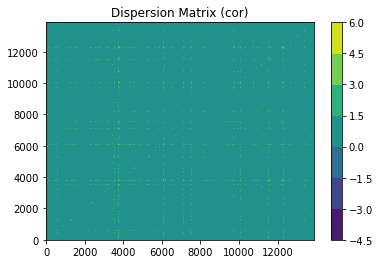

In [12]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [13]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 25 EOFs:
75.96% 

Cumulative variance explained by the first 4 EOFs:
30.87% 

1 	 21.86%
2 	 4.78%
3 	 4.22%
4 	 3.73%


### North Test

In [14]:
total_events = len(evecs)
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[22.125  4.836  4.275  3.776  3.603  3.206]
[21.863  4.778  4.224  3.732  3.56   3.168]
[21.6    4.721  4.173  3.687  3.518  3.13 ]


### Fig 2: Variance

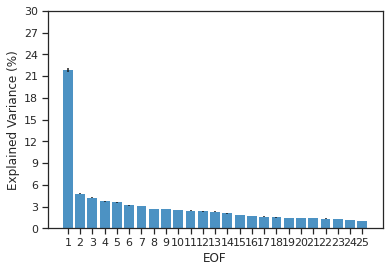

In [15]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,31,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [16]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(13880, 19)
[[ 0.172  0.129  0.123 ... -0.019 -0.053 -0.04 ]
 [ 0.214  0.148  0.121 ... -0.017 -0.095  0.033]
 [ 0.13   0.141 -0.014 ...  0.012 -0.08   0.142]
 ...
 [ 0.086 -0.02  -0.143 ... -0.054 -0.019 -0.051]
 [ 0.011 -0.066 -0.079 ... -0.082  0.015 -0.112]
 [ 0.061 -0.044 -0.008 ... -0.077  0.054 -0.055]]


### Save EOFs

In [17]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [19]:
# Calculate principal components (spatial modes)
neofs = 4
pcs = calc_eofs(Xs, evecs, neofs, mode=eofmode)

In [20]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [21]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons = ds.lon.data
lats = ds.lat.data
data = pcmodes[0][0:neofs,:,:]

print(np.min(data), np.max(data))

# Set up projection
mapcrs = ccrs.SouthPolarStereo()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-111.24869282602754 90.05963823247677


### Plot EOFs and PCs

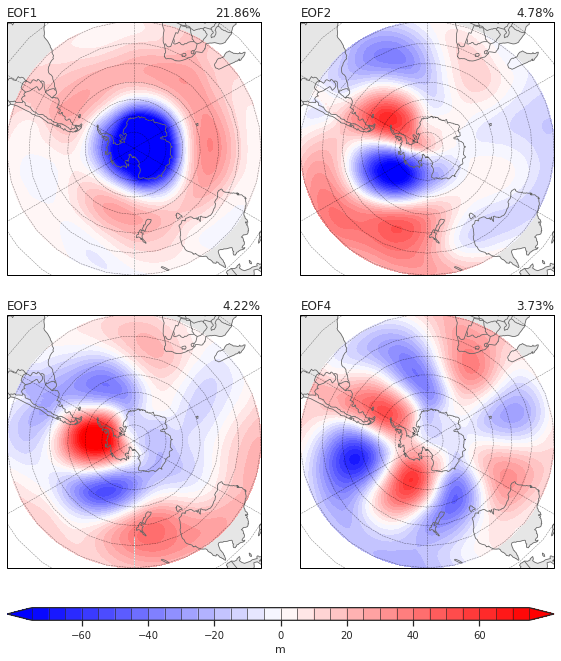

In [22]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + 'NPS'+ '.png'
nrows = 2
ncols = 2
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Add contour fill plot for extratropics
    clevs = np.arange(-75,80,5)
#     clevs = np.arange(-4500,5000,500)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/nash/DATA/repositories/AR_types/figs/AO/pc_H700s-180180-90-20cor.png


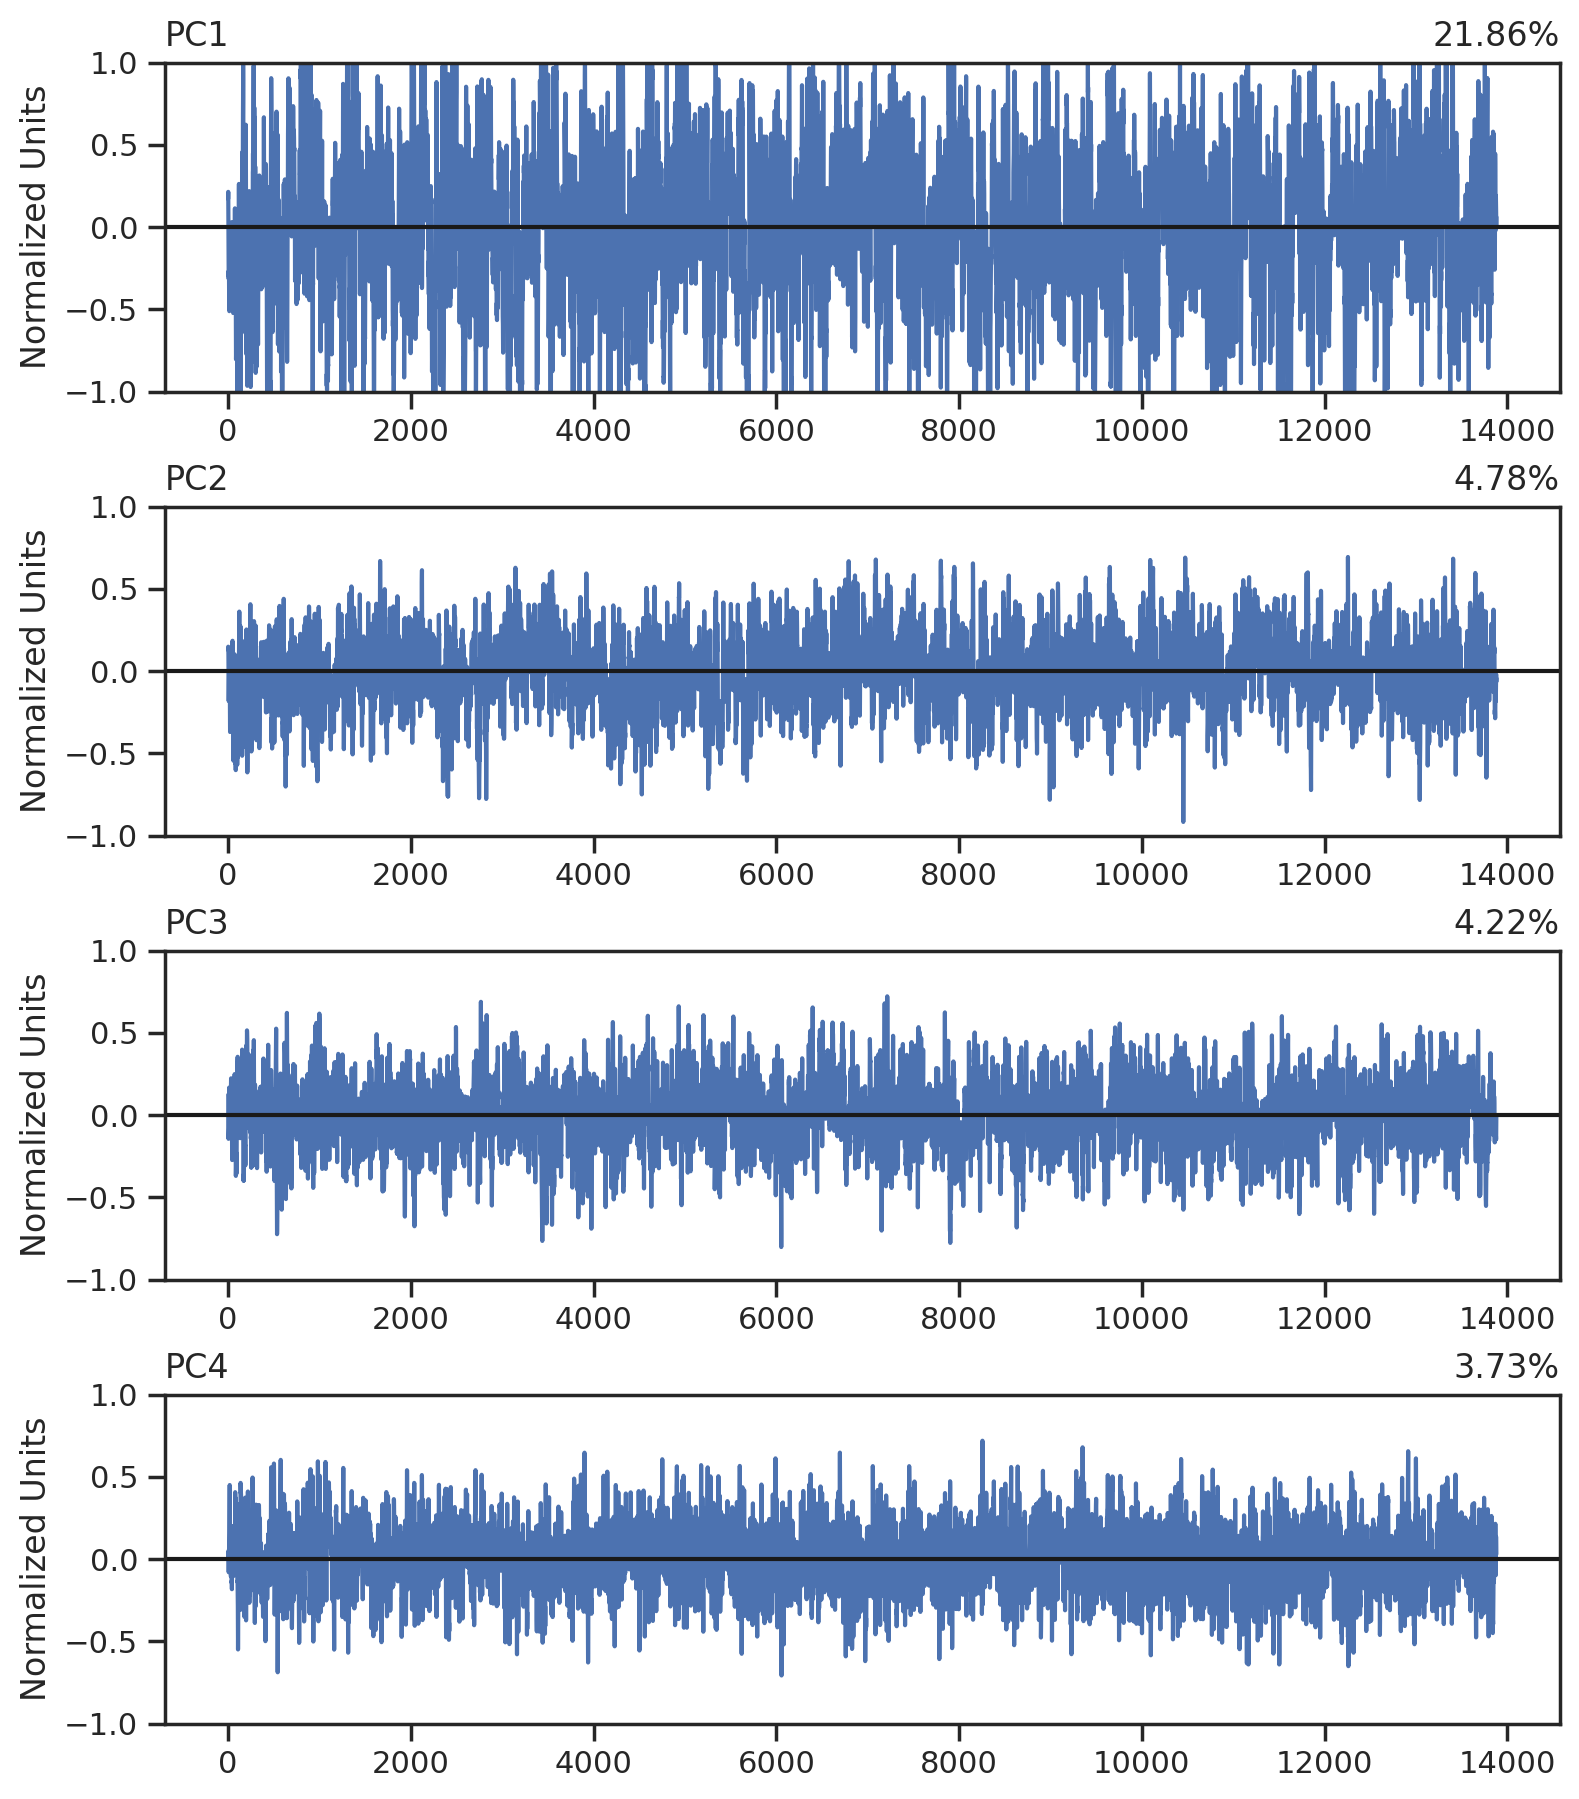

<Figure size 1800x2200 with 0 Axes>

In [24]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
results = loads[:,:4]

X, nplots = results.shape
x = np.arange(len(results))

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot(x, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-1, 1)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))